In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import time

import numpy as np
import scipy as sp
import scipy.interpolate

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from numba import jit

In [2]:
def get_month(x):
    return x.month

def get_day(x):
    return x.day

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

In [25]:
data = pd.read_excel('Bloom_EUR_OIS.xlsx')

In [26]:
data.head()

,Payment Date,Maturity Date,Market Rate,Shift (bp),Shifted Rate,Zero Rate,Discount,Source
0,01/06/2021,01/06/2021,-0.4980,0,-0.4980,-0.504920,1.000014,CASH
1,01/12/2021,01/12/2021,-0.4700,0,-0.4700,-0.476550,1.000091,DETAILED_SWAP
2,01/19/2021,01/19/2021,-0.4700,0,-0.4700,-0.476572,1.000183,DETAILED_SWAP
3,02/05/2021,02/05/2021,-0.4719,0,-0.4719,-0.478551,1.000407,DETAILED_SWAP
4,03/05/2021,03/05/2021,-0.4750,0,-0.4750,-0.481785,1.000779,DETAILED_SWAP


In [62]:
class Stripper():
    def __init__(self, data, start='2020-12-31', end='2071-01-05', freq = 3, K = 4/100): #yyyy-mm-dd
        
        self.freq = freq
        self.K = K
        self.data = data
        self.start = datetime.strptime(start,'%Y-%m-%d')
        self.end = datetime.strptime(end,'%Y-%m-%d')
        
        self.total_dates = [datetime.strptime(data['Payment Date'][0],'%m/%d/%Y')]
        
        while self.total_dates[-1] < self.end:
            self.total_dates.append(self.total_dates[-1] + relativedelta(months=+freq))
            
        while self.total_dates[-1] != self.end:
            self.total_dates[-1] -= timedelta(days=1)
            
        self.total_days = [(date-self.start).days for date in self.total_dates]
        
        ### Interpolation
        
        data_t  = [(datetime.strptime(date,'%m/%d/%Y') - self.start).days for date in data['Payment Date']]
        data_df = data['Discount']
        data_price = data['Market Rate']
        
        self.DF = np.vectorize(log_interp1d(data_t, data_df))(self.total_days)
        #self.PRICES = np.vectorize(log_interp1d(data_t, data_price))(self.total_days)
        
        
        ### Creation DataFrame
        self.delta = 1/365
        self.BC = np.array([day * self.delta for day in (self.total_days)])
        self.df = pd.DataFrame({'Date':self.total_dates,'Days':self.total_days,'DF':self.DF,'BC':self.BC})
        
        self.CF = list(K * self.df['DF'] * self.df['BC'])
        self.CF[-1] += 1
        
        self.df['CF'] = self.CF
        
        #TODO : self.PRICES = ...
        #self.df['PRICES'] = self.PRICES
        #self.PRICES = [- 1.012 for _ in self.CF]
        self.price = 1.04
        ### 
        

    def F(self,S,T):
        return (self.DF[S]/self.DF[T]-1) / (self.freq*self.delta)
    
    """
    def polynome(self, p,i,LGD=.6):

        n = len(self.DF)
        zero_target = self.DF[n-1]*p**self.BC[n-1] 
        zero_target += np.sum(
                    (self.DF*
                        (
                            p**self.BC * self.F(i-1,i) * self.freq*self.delta       \
                            +                                             \
                            (p**np.roll(self.BC,1)-p**self.BC) * (1-LGD)
                        )
                    )) 
        zero_target -= self.PRICES[i]
        
        return zero_target +1
    """
    
    
    def polynome(self, p,LGD=.6):

        n = len(self.DF)
        zero_target = self.DF[n-1]*p**self.BC[n-1] 
        
        for i in range(len(self.DF)):
            zero_target += self.DF[i]* \
                            (
                            p**self.BC[i] * self.F(i-1,i) * self.delta + \
                            (p**self.BC[i-1] - p**self.BC[i] )*(1-LGD)
                            )
            
            
        zero_target += self.DF[n-1] * p**self.BC[n-1]
        
        
        zero_target -= self.price
        
        return zero_target

    
    
    def solve_polynome(self, epsilon = 1e-8):

        left = 0
        right= 1

        while right-left>epsilon :

            mid = (left+right) / 2
            if (self.polynome(left))*(self.polynome(mid)) < 0:
                right = mid
            else:
                left = mid

        return left
    
    
    def get_PS_1year(self):
        return self.solve_polynome()
    
    def get_PS(self):
        
        self.PS_1year = self.get_PS_1year()
        
        self.PS = [self.PS_1year**delta for delta in self.BC]
        
        self.df['PS'] = self.PS
        
        
    def plotting(self):
        for i in range(len(self.DF)):
            P = np.linspace(0,1,20)
            polys = [self.polynome(p,i) for p in P]
            plt.plot(P,polys)
            plt.show()

In [63]:
stripper = Stripper(data)

In [64]:
stripper.df.head()

,Date,Days,DF,BC,CF
0,2021-01-06,6,1.000014,0.016438,0.000658
1,2021-04-06,96,1.001209,0.263014,0.010533
2,2021-07-06,187,1.002481,0.512329,0.020544
3,2021-10-06,279,1.003824,0.764384,0.030692
4,2022-01-06,371,1.005193,1.016438,0.040869


In [65]:

t1 = time.time()
stripper.get_PS()
print("Execution time = {}s".format(round(time.time()-t1,3)))

Execution time = 0.039s


In [69]:
stripper.df

,Date,Days,DF,BC,CF,PS
0,2021-01-06,6,1.000014,0.016438,0.000658,0.999759
1,2021-04-06,96,1.001209,0.263014,0.010533,0.996156
2,2021-07-06,187,1.002481,0.512329,0.020544,0.992525
3,2021-10-06,279,1.003824,0.764384,0.030692,0.988868
4,2022-01-06,371,1.005193,1.016438,0.040869,0.985225
...,...,...,...,...,...,...
196,2070-01-06,17903,1.066163,49.049315,2.091782,0.487570
197,2070-04-06,17993,1.066839,49.295890,2.103631,0.485813
198,2070-07-06,18084,1.067520,49.545205,2.115619,0.484042
199,2070-10-06,18176,1.068205,49.797260,2.127747,0.482259


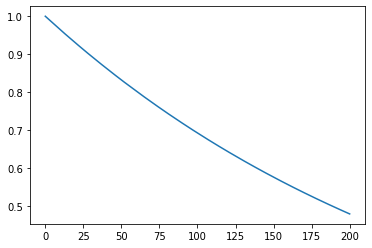

In [67]:
plt.plot(stripper.df['PS'])